In [1]:
# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Global Poverty

In 1800, 85% of the world's 1 billion people lived in *extreme poverty*, defined by the United Nations as "a condition characterized by severe deprivation of basic human needs, including food, safe drinking water, sanitation facilities, health, shelter, education and information." A common measure of extreme poverty is a person living on less than \$1.25 per day.

In 2018, the proportion of people living in extreme poverty was estimated to be 8%. Although the world rate of extreme poverty has declined consistently for hundreds of years, the number of people living in extreme poverty is still over 600 million. The United Nations recently adopted an [ambitious goal](http://www.un.org/sustainabledevelopment/poverty/): "By 2030, eradicate extreme poverty for all people everywhere."
In this section, we will examine extreme poverty trends around the world.

In [53]:
# Read the data sets
population = Table.read_table("population.csv")
countries = Table.read_table('countries.csv').where('country', are.contained_in(population.group('geo').column(0)))
poverty = Table.read_table('poverty.csv')
population

geo,time,population_total
afg,1800,3280000
afg,1801,3280000
afg,1802,3280000
afg,1803,3280000
afg,1804,3280000
afg,1805,3280000
afg,1806,3280000
afg,1807,3280000
afg,1808,3280000
afg,1809,3280000


Assign `latest` to a three-column table with one row for each country that appears in the `poverty` table. The first column should contain the 3-letter code for the country. The second column should contain the *most recent year* for which an extreme poverty rate is available for the country. The third column should contain the poverty rate in that year. 

In [3]:
def first(values):
    return values.item(0)

latest = poverty.sort("time", descending = True).sort('geo', distinct = True)

# OR latest = poverty.sort("time", descending = True).group('geo', first)

latest.relabel(0, 'geo').relabel(1, 'time').relabel(2, 'poverty_percent')

geo,time,poverty_percent
ago,2009,43.37
alb,2012,0.46
arg,2011,1.41
arm,2012,1.75
aus,2003,1.36
aut,2004,0.34
aze,2008,0.31
bdi,2006,81.32
bel,2000,0.5
ben,2012,51.61


In [101]:
# Join the population table to the latest poverty table
poverty_and_pop = population.where('geo', are.contained_in(latest.column('geo'))).join('geo',latest.drop(1),'geo')
# Compute poverty_total and round the values to the nearest integer using rint in the numpy module
poverty_total = np.rint(poverty_and_pop.column('population_total')*poverty_and_pop.column('poverty_percent')/100)
# Add the computed field to the table. Filter the year to 2015
recent = poverty_and_pop.with_column("poverty_total", poverty_total).where('time', 2018).drop(1)
# Change the order of columns
recent = recent.select(0, 2, 1, 3)

# Test
recent

geo,poverty_percent,population_total,poverty_total
ago,43.37,30774205,1.33468e+07
alb,0.46,2934363,13498
arg,1.41,44688864,630113
arm,1.75,2934152,51348
aus,1.36,24772247,336903
aut,0.34,8751820,29756
aze,0.31,9923914,30764
bdi,81.32,11216450,9.12122e+06
bel,0.5,11498519,57493
ben,51.61,11485674,5.92776e+06


In [102]:
poverty_map = countries.join("country", recent, "geo").select("latitude", "longitude", "name", "world_4region", "poverty_total").relabel(3,"region")
poverty_map

latitude,longitude,name,region,poverty_total
-12.5,18.5,Angola,africa,1.33468e+07
41,20,Albania,europe,13498
-34,-64,Argentina,americas,630113
40.25,45,Armenia,europe,51348
-25,135,Australia,asia,336903
47.3333,13.3333,Austria,europe,29756
40.5,47.5,Azerbaijan,europe,30764
-3.5,30,Burundi,africa,9.12122e+06
50.75,4.5,Belgium,europe,57493
9.5,2.25,Benin,africa,5.92776e+06


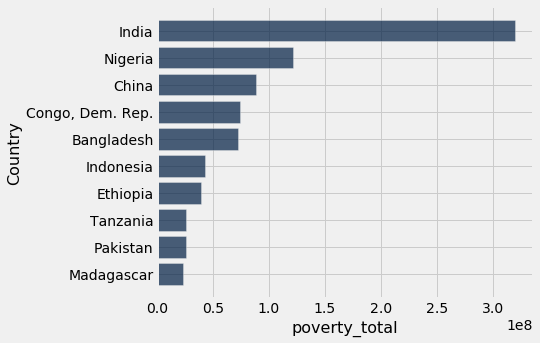

In [103]:
# The 10 countries with the largest number of people living in extreme poverty.
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
largest = poverty_map.sort('poverty_total', descending=True).take(np.arange(10)).select(2, 4).relabel(0, "Country")
largest.barh("Country", "poverty_total")

[Text(0, 0.5, 'Country'),
 Text(0.5, 0, 'Number of Poor People in 100s of Millions')]

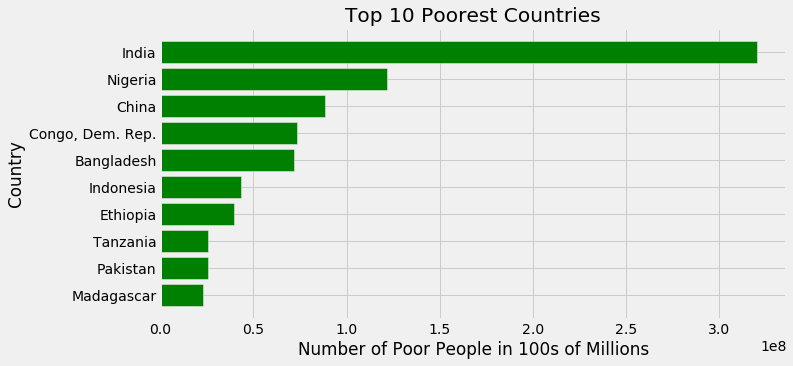

In [127]:
largest_10 = largest.sort('poverty_total').take(np.arange(10))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

ax.barh(largest_10.column("Country"), largest_10.column("poverty_total"), color="green")
ax.set(title = "Top 10 Poorest Countries")
ax.set(xlabel="Number of Poor People in 100s of Millions", ylabel="Country")

In [105]:
largest.set_format(1, NumberFormatter)

Country,poverty_total
India,"319,962,453.00"
Nigeria,"121,501,410.00"
China,"88,581,875.00"
"Congo, Dem. Rep.","73,689,176.00"
Bangladesh,"71,954,224.00"
Indonesia,"43,220,787.00"
Ethiopia,"39,562,083.00"
Tanzania,"25,692,937.00"
Pakistan,"25,583,680.00"
Madagascar,"23,024,606.00"


In [106]:
sum(largest[1]) / sum(poverty_map[4])

0.7234397013923676

In [111]:
# Population in 2015
pop_2018 = population.where("time", 2018).sort(2, descending = True).set_format(2, NumberFormatter)

In [112]:
pop_2018

geo,time,population_total
chn,2018,"1,415,045,928"
ind,2018,"1,354,051,854"
usa,2018,"326,766,748"
idn,2018,"266,794,980"
bra,2018,"210,867,954"
pak,2018,"200,813,818"
nga,2018,"195,875,237"
bgd,2018,"166,368,149"
rus,2018,"143,964,709"
mex,2018,"130,759,074"


In [113]:
sum(largest[1]) / max(pop_2018[2])

0.5885132167950382

In [119]:
# Total world population in 2018. The total was calculated using a for loop
s = 0
for i in range(len(pop_2018[2])):
    s = s + pop_2018[2].item(i)

Table().with_column("2018 Total Population", make_array(s)).set_format(0, NumberFormatter)

2018 Total Population
"7,623,764,439"


In [115]:
round(sum(largest[1]) / s * 100)

11.0

In [129]:
def population_for_country_in_year(row_of_poverty_table):
    """Optional: Define a function to return the population 
    of a country in a year using a row from the poverty table."""
    return population.where('time', row_of_poverty_table.item('time')).where('geo', row_of_poverty_table.item('geo')).column('population_total').item(0)

def poverty_timeline(country):
    """Draw a timeline of people living in extreme poverty in a country."""
    geo = countries.where('name', country).column('country').item(0)
    country_poverty = poverty.where('geo', geo)
    Table().with_columns('Year', country_poverty.column(1), 'Number in poverty', country_poverty.column(2) / 100 * country_poverty.apply(population_for_country_in_year)).plot(0, 1)

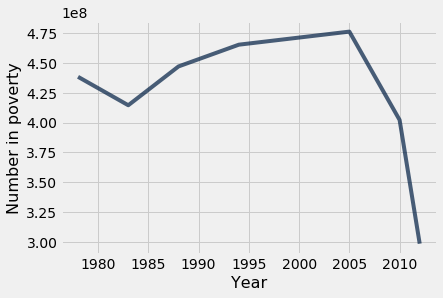

In [130]:
poverty_timeline("India")

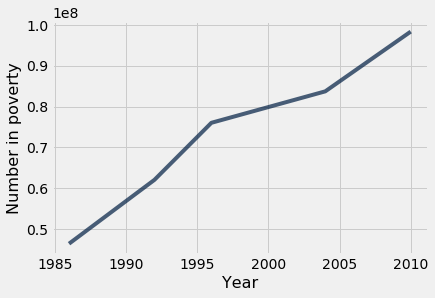

In [131]:
poverty_timeline("Nigeria")